**Peter Misiun**

**20886060**

**Computer Simulation STAT2005**

**Project: Forecasting the Price Volatility of Bitcoin Using a
Hybrid ARIMA-GARCH Model**

**Install arch for model**

In [1]:
!pip install arch

**Import neccessary libraries**

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from arch import arch_model
from itertools import product
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
import warnings

warnings.filterwarnings("ignore")

# **Step 1: Gathering Historical Market Data**

**Get historical data for Bitcoin**

Historic Bitcoin data was gathered from Yahoo Finance using the ‘yfinance’ Python library, covering the period from January 1st, 2020, to the present. The data used is the daily closing price of Bitcoin in USD. The data gathered incorporates both bull and bear market scenarios, leading to a more comprehensive outlook on the price of Bitcoin.

Handle missing values and irregularities within the dataset (interpolation).

In [3]:
# def ticker symbol for bitcoin
bitcoin_ticker = "BTC-USD"

# def start date for data
# end date = current date if not defined
start_date = "2020-01-01"

# download data
bitcoin_data_raw = yf.download(bitcoin_ticker, start=start_date, progress=False)
print(f"Successfully downloaded Bitcoin data. Length = {len(bitcoin_data_raw)}.")

# make copy with close price
bitcoin_prices = bitcoin_data_raw[["Close"]].copy()
print("\nBitcoin Daily Close Prices Preview:\n")
display(bitcoin_prices)

# use interpolation for missing values
bitcoin_prices.interpolate(method='linear', inplace=True)

YF.download() has changed argument auto_adjust default to True
Successfully downloaded Bitcoin data. Length = 1971.

Bitcoin Daily Close Prices Preview:



Price,Close
Ticker,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383
...,...
2025-05-20,106791.085938
2025-05-21,109678.078125


**Create visualisation for Bitcoin price history**

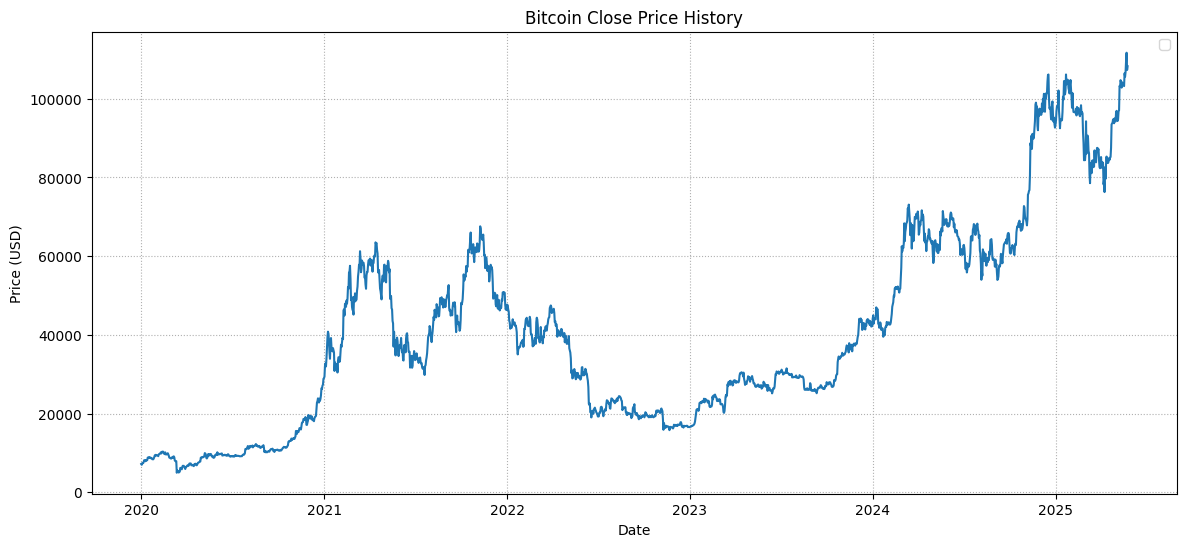

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(bitcoin_prices["Close"])
plt.title("Bitcoin Close Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

# **Step 2: Preparing Data for Analysis**

**Stationarity - Converting prices to log returns (necessary transformation to stabilise variance).**





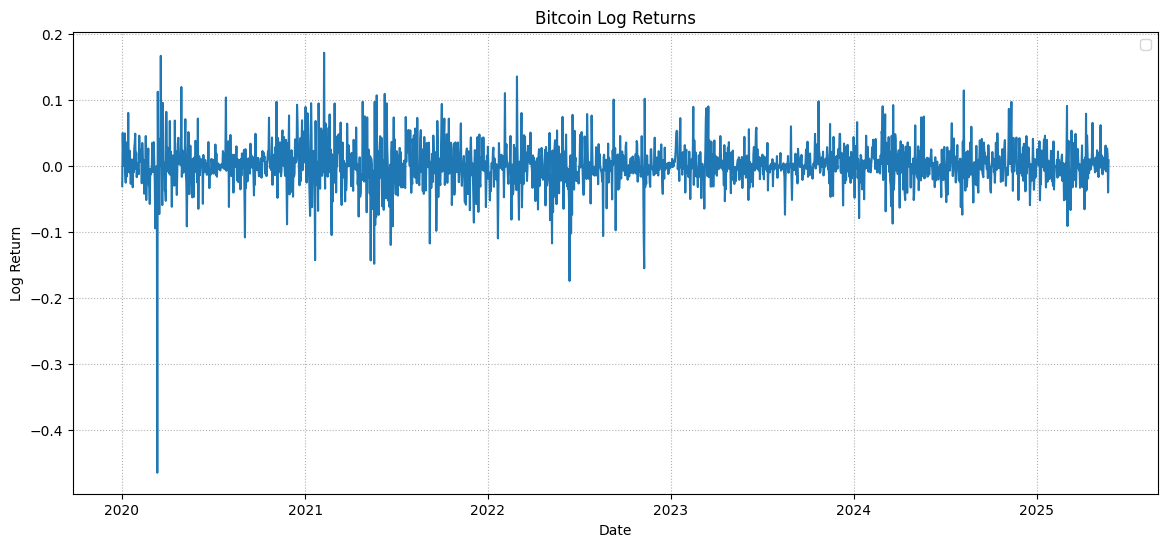

In [5]:
# converting prices to log returns
bitcoin_prices["Log_Returns"] = np.log(bitcoin_prices["Close"] / bitcoin_prices["Close"].shift(1))

# drop first nan value from log conversion
bitcoin_prices.dropna(inplace=True)

# visualisation of log returns
plt.figure(figsize=(14, 6))
plt.plot(bitcoin_prices["Log_Returns"])
plt.title("Bitcoin Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

**ADF Test - Stationarity**

An Augmented Dickey-Fuller (ADF) test was employed to ensure log returns. The conversion to log returns is required for the ARIMA model.

In [6]:
# use adf to check for stationarity in log returns
print("\n*** Performing ADF test on log returns ***")

# get adf results + print info
adf_result = adfuller(bitcoin_prices["Log_Returns"])
print(f"\nADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("\nCritical Values:")
for key, value in adf_result[4].items():
    print(f"{key}: {value}")

# init arima d order = 0 as already stationary
d_order = 0
print("\nd_order = 0 assumed")

# get stationarity results
if adf_result[1] <= 0.05:
    print("\n** Reject null hypothesis as log retuns are most likely stationarity **")
    d_order = 0
else:
    print("\nAccept null hypothesis as log retuns are most likely non-stationarity")
    d_order = 1


*** Performing ADF test on log returns ***

ADF Statistic: -14.526275851206389
p-value: 5.4219665671125896e-27

Critical Values:
1%: -3.43368905179724
5%: -2.86301499720276
10%: -2.567555228165442

d_order = 0 assumed

** Reject null hypothesis as log retuns are most likely stationarity **


**Split data into an 80:20 ratio.** This allows 80% of the data going towards the development/training of the model, with the remaining 20% of it going to testing/validation of the model. This split is important as it allows our model to be trained with an adequate amount of historical data, and be tested with recent data, simulating an environment of forecasting to see if the model performs as desired.

In [7]:
# 80:20 split for data
train_size = int(len(bitcoin_prices) * 0.8)
train_data = bitcoin_prices[:train_size].copy()
test_data = bitcoin_prices[train_size:].copy()

# get amount of steps needed
n_steps_forecast = len(test_data)

# print info
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

Training data size: 1576
Testing data size: 394


**Time series decomposition**

Decompose the close price and log returns in order to identify seasonal trends

In [8]:
# decompose close price for training data: yearly (365)
decompose_close = seasonal_decompose(train_data["Close"], model='additive', period=365)

# decompose log returns: monthly (30)
decompose_log_return = seasonal_decompose(train_data["Log_Returns"].dropna(), model='additive', period=30)

**Visualisations of ACF and PACF for log returns**

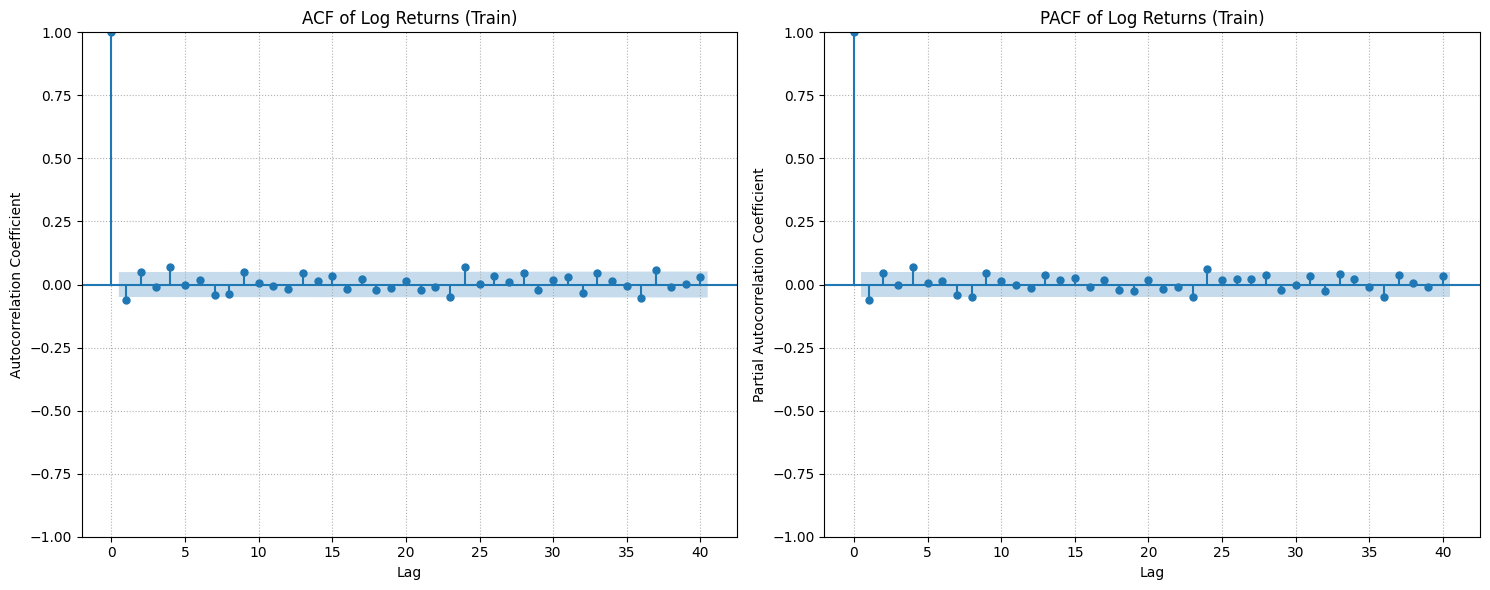

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# ACF plot
plot_acf(train_data["Log_Returns"].dropna(), ax=ax[0], lags=40, title="ACF of Log Returns (Train)")
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation Coefficient')
ax[0].grid(True, linestyle=':')

# PACF plot
plot_pacf(train_data["Log_Returns"].dropna(), ax=ax[1], lags=40, title="PACF of Log Returns (Train)")
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation Coefficient')
ax[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()
plt.close()

# **Step 3: Linear Trend Identification with ARIMA Model**



**Search for optimal ARIMA parameters using AIC**

ARIMA is specified by three parameters being p (autoregressive order), d (differencing order) and q (moving average order). The optimal parameter values were determined using a grid search based on Akaike Information Criterion (AIC) and Bayesian Information (BIC). These criteria identify the parameter values that best explain the data. Once complete, the model is fitted using ‘ARIMA’ from the ‘statsmodel’ python library with the optimal parameters incorporated.

In [10]:
# parameters = p, d, q
# d already uncovered from adf
p_range = range(0, 4)
q_range = range(0, 4)

optimal_arima_aic = np.inf
optimal_arima_order = None

# fit model using best AIC found
for p_val in p_range:
    for q_val in q_range:
        if not (p_val == 0 and q_val == 0 and d_order == 0): # 0, 0, 0 = white noise need skipped
            temp_model = ARIMA(train_data["Log_Returns"], order=(p_val, d_order, q_val))
            temp_result = temp_model.fit()
            if temp_result.aic < optimal_arima_aic:
                optimal_arima_aic = temp_result.aic
                optimal_arima_order = (p_val, d_order, q_val)
                optimal_arima = temp_result

fitted_arima = optimal_arima

# print info
print(f"Optimal ARIMA order (p,d,q) found: {optimal_arima_order} with AIC: {optimal_arima_aic:.2f}")
print("\n")
print(optimal_arima.summary())

Optimal ARIMA order (p,d,q) found: (1, 0, 1) with AIC: -6082.25


                               SARIMAX Results                                
Dep. Variable:            Log_Returns   No. Observations:                 1576
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3045.124
Date:                Sat, 24 May 2025   AIC                          -6082.249
Time:                        09:50:23   BIC                          -6060.798
Sample:                    01-02-2020   HQIC                         -6074.277
                         - 04-25-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.528      0.126      -0.000       0.003
ar.L1         -0.7068      0.125     -5.650      0.000      -0.95

**Analysis of ARIMA residuals**

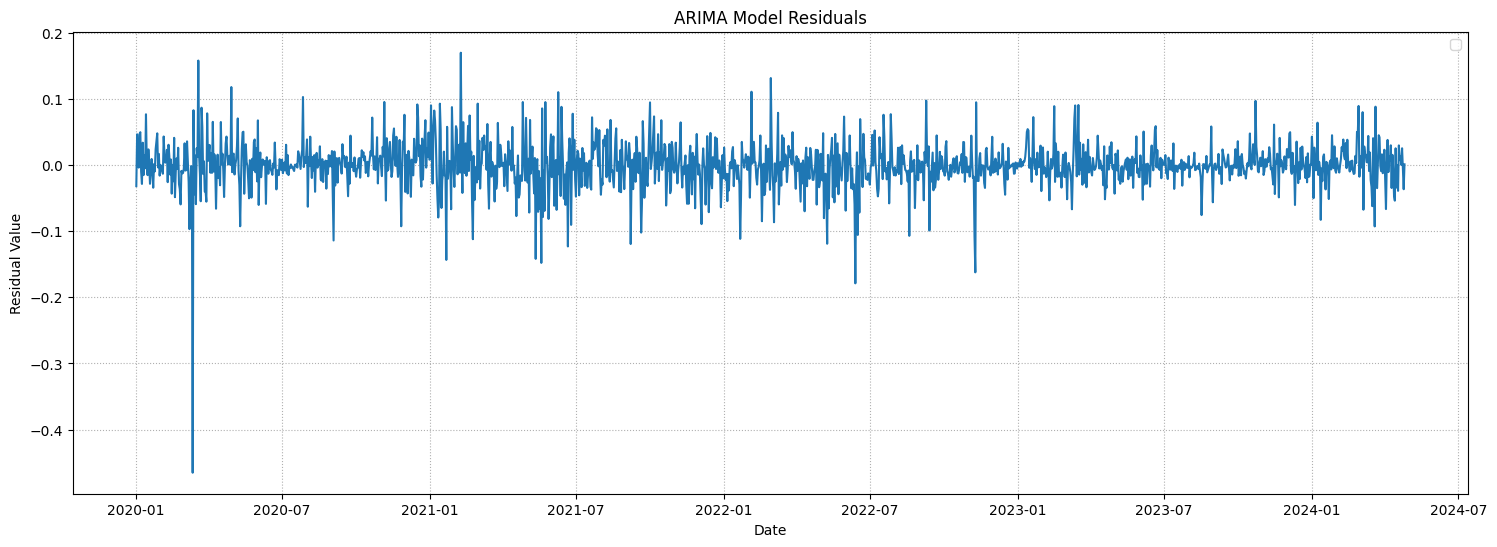

In [11]:
# alignment of index
arima_residuals = pd.Series(fitted_arima.resid, index=train_data.index[-len(fitted_arima.resid):])

# residuals free of nan values
arima_residuals.dropna(inplace=True) # Ensure no NaNs in residuals

# visualisation of residuals
plt.figure(figsize=(18, 6))
plt.plot(arima_residuals)
plt.title("ARIMA Model Residuals")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

**Ljung-Box test on ARIMA residuals (check for autocorrelation)**

In [12]:
# perform ljung box test
lb_results = acorr_ljungbox(arima_residuals, lags=[10], return_df=True)

# print results
print(lb_results)
if not lb_results.empty and lb_results["lb_pvalue"].iloc[0] > 0.05:
    print("\nPassed (pvalue > 0.05) - Test suggests residuals have no significant autocorrelation")
else:
    print("\nFailed (pvalue < 0.05)- Test suggests residuals have significant autocorrelation")

      lb_stat  lb_pvalue
10  15.431069   0.117118

Passed (pvalue > 0.05) - Test suggests residuals have no significant autocorrelation


To ensure the ARIMA model properly captured the underlying trends in the data, diagnostic tests were conducted. The Ljung-Box test was used on the residuals to identify hidden correlations, implying the model required adjustments. ACF and PACF plots were created to visually confirm that no significant autocorrelation was left in the residuals.

**Visualisation of ACF and PACF of residuals**

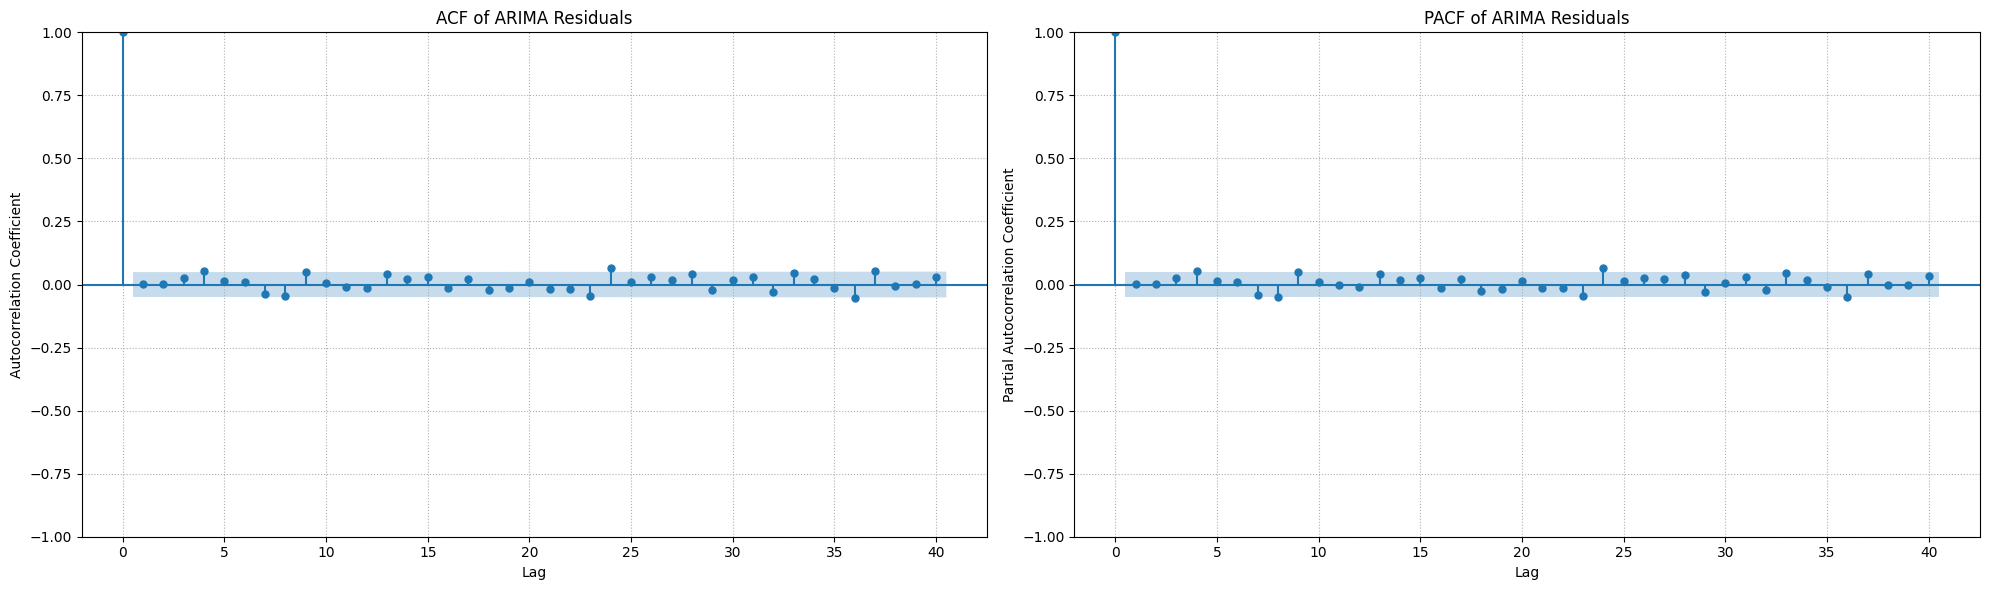

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# ACF plot
plot_acf(arima_residuals, ax=ax[0], lags=40, title="ACF of ARIMA Residuals")
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation Coefficient')
ax[0].grid(True, linestyle=':')

# PACF plot
plot_pacf(arima_residuals, ax=ax[1], lags=40, title="PACF of ARIMA Residuals")
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation Coefficient')
ax[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()
plt.close()

**Visualisation of actual vs ARIMA forecasted log returns**

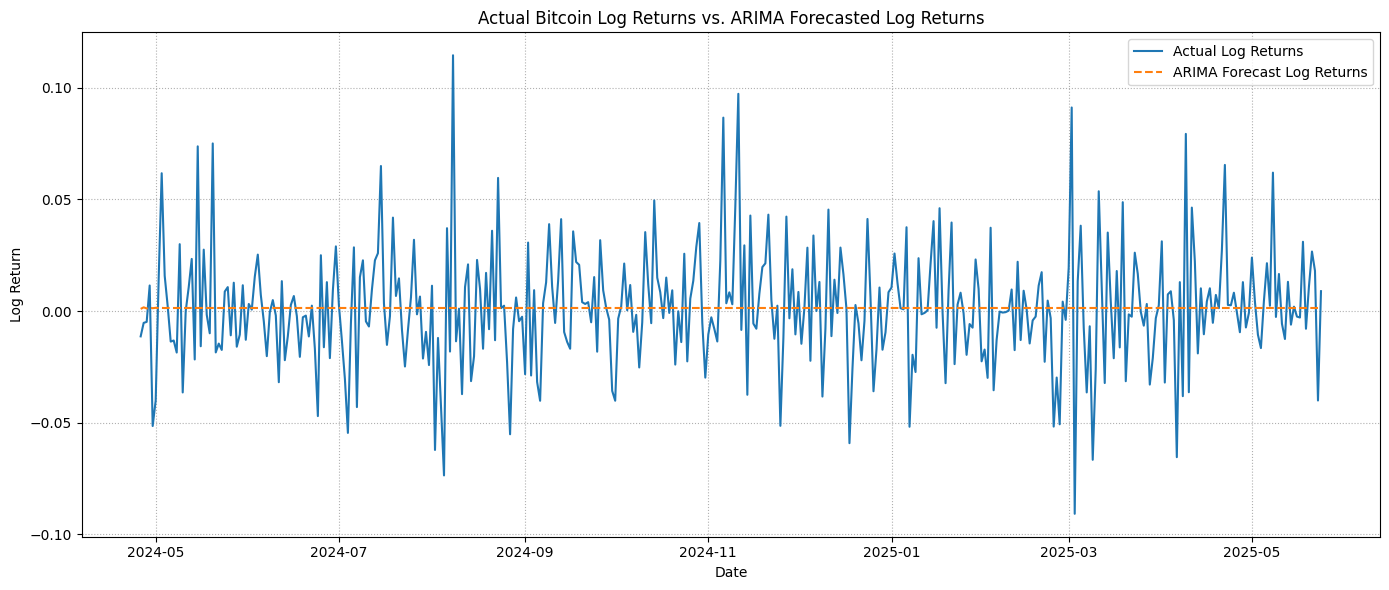

In [14]:
# generate conditional mean forecasts for ARIMA
arima_forecast_obj = fitted_arima.get_forecast(steps=n_steps_forecast)
arima_mean_forecasts = pd.Series(arima_forecast_obj.predicted_mean.values, index=test_data.index)

plt.figure(figsize=(14, 6))
plt.plot(test_data["Log_Returns"].index, test_data["Log_Returns"], label="Actual Log Returns")
plt.plot(arima_mean_forecasts.index, arima_mean_forecasts, label="ARIMA Forecast Log Returns", linestyle='--')
plt.title("Actual Bitcoin Log Returns vs. ARIMA Forecasted Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

# **Step 4: Volatility Clustering Identification with GARCH Model**

**Search for optimal GARCH parameters using AIC**

GARCH is specified by two parameters being p (order of autoregressive component for squared residuals) and q (order of moving average component for conditional variance). The optimal parameter values were determined using a grid search based on Akaike Information Criterion (AIC) and Bayesian Information (BIC). These criteria identify the parameter values that best explain the data. Once complete, the model is fitted using ‘arch_model’ from the ‘arch’ python package with the optimal parameters incorporated.

In [15]:
# init best pararmeters
optimal_garch_aic = np.inf
optimal_garch_order = None
garch_results = None

# search + fit garch orders
for p in range(1, 3):
    for q in range(1, 3):
        model = arch_model(arima_residuals, vol="Garch", p=p, q=q, mean="Zero")
        res = model.fit(disp="off")
        if res.aic < optimal_garch_aic:
            optimal_garch_aic = res.aic
            optimal_garch_order = (p, q)
            garch_results = res

# print results
print(f"Optimal GARCH order {optimal_garch_order} with AIC: {optimal_garch_aic:.2f}")
print("\n")
print(garch_results.summary())

Optimal GARCH order (2, 2) with AIC: -6238.57


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3124.29
Distribution:                  Normal   AIC:                          -6238.57
Method:            Maximum Likelihood   BIC:                          -6211.76
                                        No. Observations:                 1576
Date:                Sat, May 24 2025   Df Residuals:                     1576
Time:                        09:50:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega     

**GARCH Conditional Volatility Information**

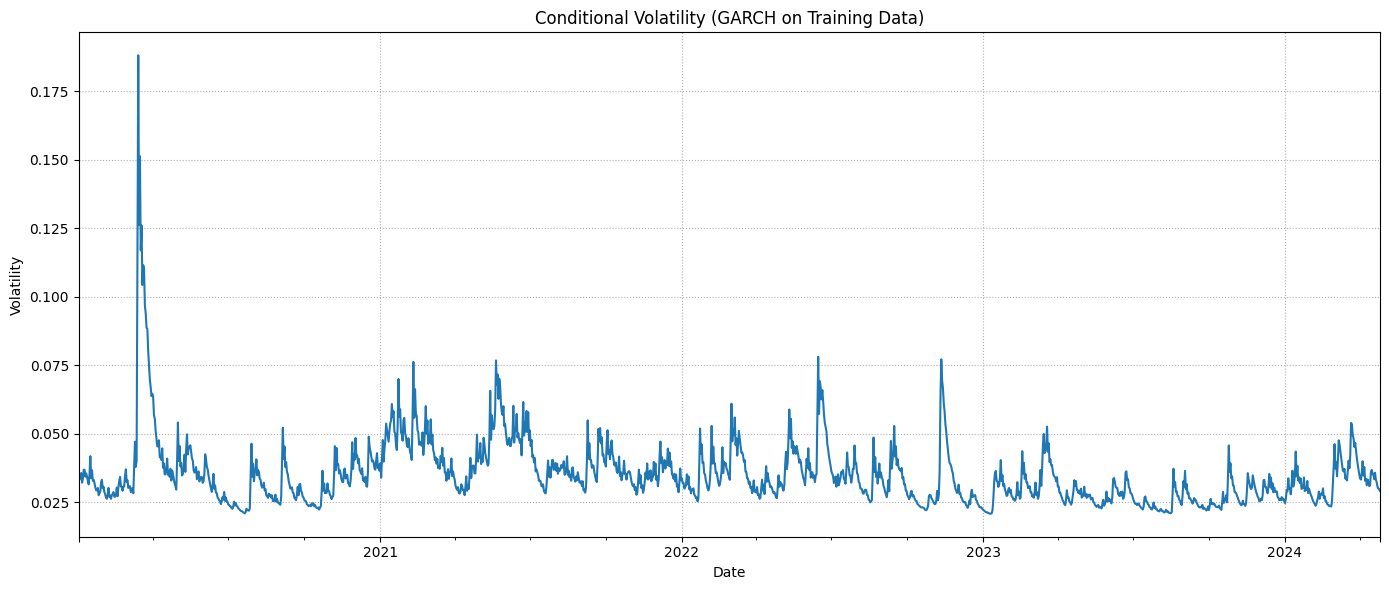

In [16]:
cond_vol_train = garch_results.conditional_volatility

# visualisation
plt.figure(figsize=(14, 6))
cond_vol_train.plot(title="Conditional Volatility (GARCH on Training Data)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

# **Step 5: Simulation of Hybrid ARIMA-GARCH Model**

**Generating forecasts for both models**

Conditional mean forecasts of log returns using ARIMA have been previously created. Due to this, we generate conditional variance forecasts of residuals using GARCH. Combining these components creates a complete distribution of possible future returns.

In [17]:
# generate volatility forecasts for GARCH + print head
garch_forecast = garch_results.forecast(horizon=n_steps_forecast, reindex=False)
pred_cond_var_test = pd.Series(garch_forecast.variance.values.flatten(), index=test_data.index)
pred_cond_vol_test = np.sqrt(pred_cond_var_test)

**Simulation of future price paths using Monte Carlo**

Once the above is completed, a Monte Carlo simulation can be employed. Using this approach allowed 1000 simulations to be run, simulating the price paths based of the estimated conditional mean and variance gained from the ARIMA-GARCH model. Using these simulated price predictions allows for multiple potential outcomes rather than a singular forecast.

In [18]:
# parameters for simulation
num_simulations = 1000
last_actual_price_train = train_data["Close"].iloc[-1]
sim_prices = np.zeros((n_steps_forecast, num_simulations))
sim_returns = np.zeros((n_steps_forecast, num_simulations))

# perform simulations
for s_idx in range(num_simulations):
    current_sim_price = last_actual_price_train
    for t_idx in range(n_steps_forecast):
        mean_t = arima_mean_forecasts.iloc[t_idx]
        vol_t = pred_cond_vol_test.iloc[t_idx]

        # non zero/nan for volatility avoiding scaling issues
        if pd.isna(vol_t) or vol_t == 0:
            vol_t = 1e-6

        random_shock = np.random.normal(0, 1)
        simulated_log_return = mean_t + vol_t * random_shock
        # store log return before converting to price
        sim_returns[t_idx, s_idx] = simulated_log_return
        current_sim_price = current_sim_price * np.exp(simulated_log_return)
        sim_prices[t_idx, s_idx] = current_sim_price

# save results
print(f"Monte Carlo simulation completed with {num_simulations} paths")
sim_prices_df = pd.DataFrame(sim_prices, index=test_data.index)
sim_returns_df = pd.DataFrame(sim_returns, index=test_data.index)

# calc stats
mean_sim_prices = sim_prices_df.mean(axis=1)
mean_sim_returns = sim_returns_df.mean(axis=1)

Monte Carlo simulation completed with 1000 paths


**Visualisation of actual Bitcoin price with Monte Carlo simulated price paths**

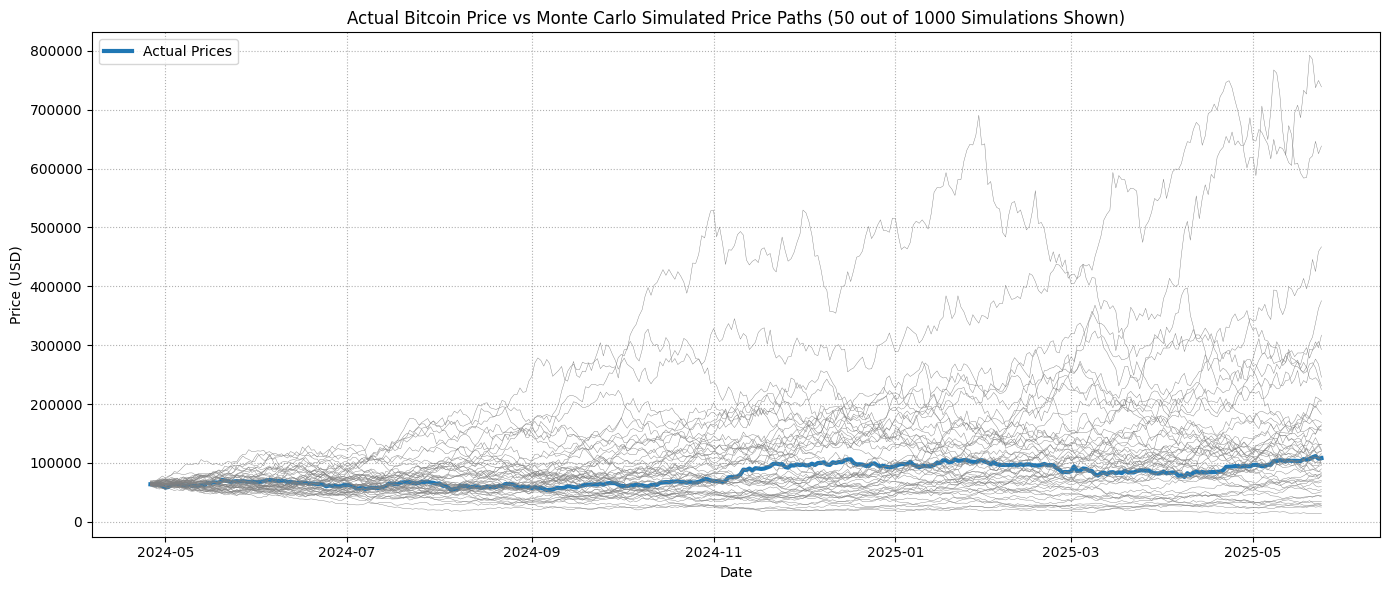

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(test_data["Close"].index, test_data["Close"], label="Actual Prices", linewidth=3)

# plot only 50 simulated paths to avoid clutter
subset_sims = sim_prices_df.iloc[:, :50]
plt.plot(subset_sims.index, subset_sims,
         color='grey',
         linewidth=0.3)

plt.title(f"Actual Bitcoin Price vs Monte Carlo Simulated Price Paths (50 out of {num_simulations} Simulations Shown)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.close()

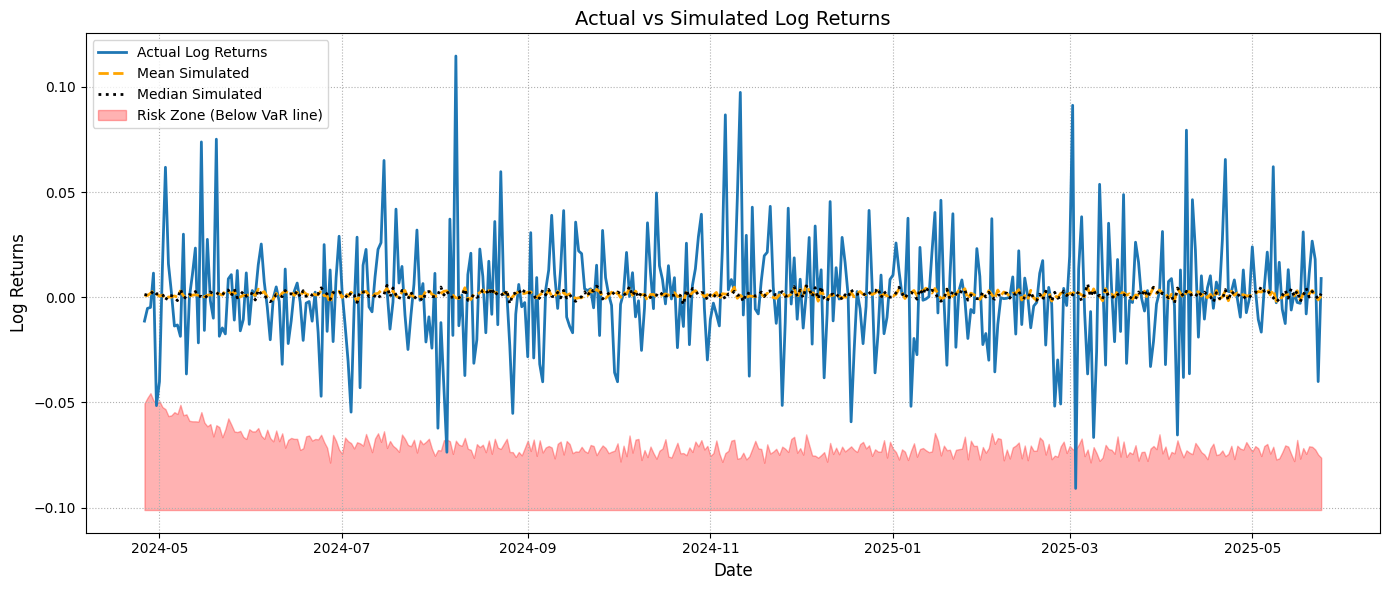

In [20]:
# calc stats from simulated returns
mean_sim_returns = sim_returns_df.mean(axis=1)
median_sim_returns = sim_returns_df.median(axis=1)
percentile_5_simulated = sim_returns_df.quantile(0.05, axis=1)

# align indices
aligned_index = test_data['Log_Returns'].index
mean_sim_aligned = mean_sim_returns.loc[aligned_index]
median_sim_aligned = median_sim_returns.loc[aligned_index]
percentile_5_aligned = percentile_5_simulated.loc[aligned_index]

plt.figure(figsize=(14, 6))

# actual returns plotted
plt.plot(test_data['Log_Returns'].index, test_data['Log_Returns'],
         label='Actual Log Returns', linewidth=2)

# mean simulated return plotted
plt.plot(aligned_index, mean_sim_aligned,
         label='Mean Simulated', color='orange', linestyle='--', linewidth=2)

# median simulated return plotted
plt.plot(aligned_index, median_sim_aligned,
         label='Median Simulated', color='black', linestyle=':', linewidth=2)

# fill in VaR region
plt.fill_between(aligned_index,
                 percentile_5_aligned,
                 plt.ylim()[0],  # fills to bottom of plot
                 color='red', alpha=0.3, label='Risk Zone (Below VaR line)')

plt.title('Actual vs Simulated Log Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

**Calculate value at risk (VAR)**

This allows for valuable information for investors looking to invest in Bitcoin

In [21]:
# 95% 1 day VAR from forecasted log returns + volatility
VAR_95_returns = norm.ppf(0.05, loc=arima_mean_forecasts, scale=pred_cond_vol_test)
VAR_95_returns_series = pd.Series(VAR_95_returns, index=test_data.index)

# plot price lower bound from VAR
forecasted_lower_bound_price = test_data["Close"].shift(1).fillna(method='bfill') * np.exp(VAR_95_returns_series)


**Visualisation of VAR for log returns**

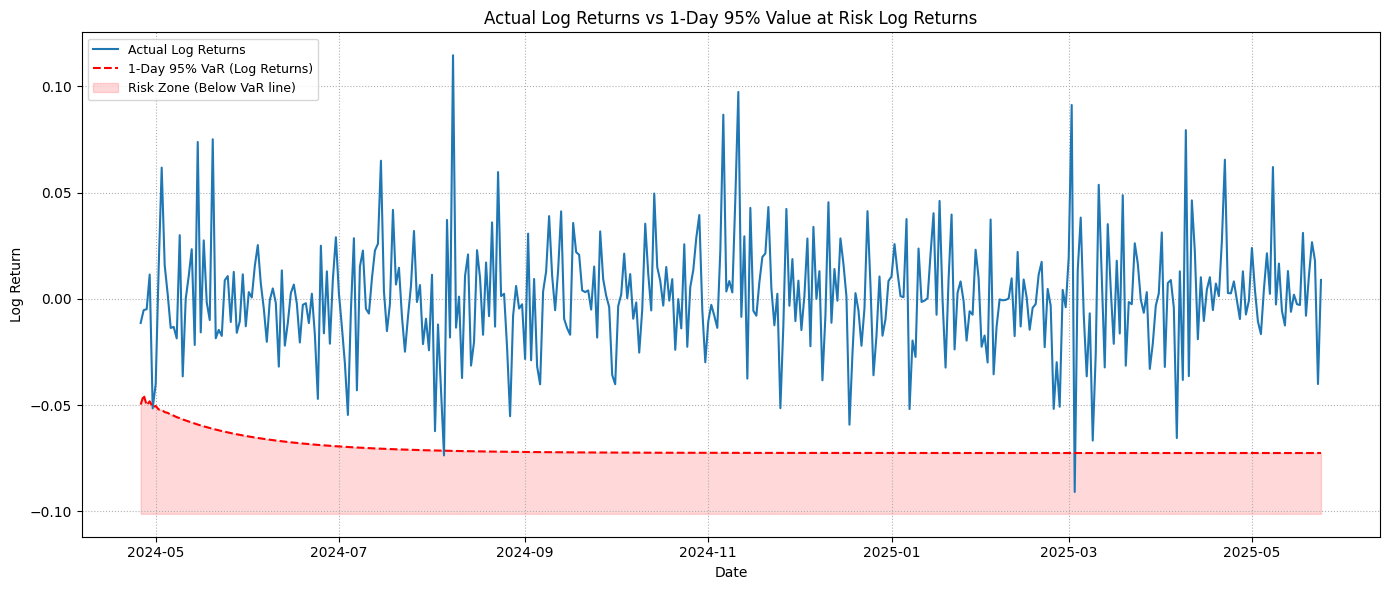

In [22]:
plt.figure(figsize=(14, 6))

# actual log returns plotted
plt.plot(test_data["Log_Returns"].index,
         test_data["Log_Returns"],
         label="Actual Log Returns",
         linewidth=1.5)

# VaR line plotted
plt.plot(VAR_95_returns_series.index,
         VAR_95_returns_series,
         label="1-Day 95% VaR (Log Returns)",
         color='red',
         linestyle='--',
         linewidth=1.5)

# fill are from VaR line to bottom
plt.fill_between(VAR_95_returns_series.index,
                 plt.ylim()[0],
                 VAR_95_returns_series,
                 color='red',
                 alpha=0.15,
                 label='Risk Zone (Below VaR line)')

plt.title("Actual Log Returns vs 1-Day 95% Value at Risk Log Returns", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Log Return", fontsize=10)
plt.legend(fontsize=9, loc='upper left')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
plt.close()

# **Step 6: Validating Model Performance**

**Evaluating performance of ARIMA forecasts and simulations**

Mean square error (MSE), root mean square error (RMSE) and mean absolute error (MAE) were used to assess the accuracy of predicted price movements

In [23]:
# evaluate ARIMA mean forecast for log returns
actual_returns_test = test_data["Log_Returns"]

# already log return forecasts
forecast_arima_returns_test = arima_mean_forecasts

# assign values + print info
mse_hybrid = mean_squared_error(actual_returns_test, mean_sim_returns)
mae_hybrid = mean_absolute_error(actual_returns_test, mean_sim_returns)
rmse_hybrid = np.sqrt(mse_hybrid)
print(f"\nEvaluation of ARIMA mean forecast (Log Returns on Test Set):")
print(f"MSE: {mse_hybrid:.6f}")
print(f"MAE: {mae_hybrid:.6f}")
print(f"RMSE: {rmse_hybrid:.6f}")


Evaluation of ARIMA mean forecast (Log Returns on Test Set):
MSE: 0.000693
MAE: 0.018971
RMSE: 0.026327


**Diebold Mariano Test**

A Diebold Mariano test was employed to compare the hybrid model against the standalone ARIMA and GARCH models in terms of forecast accuracy

In [24]:
def diebold_mariano_test(e1, e2, h=1, alternative='two-sided'):
    d = (e1**2 - e2**2)  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)

    dm_stat = mean_d / np.sqrt(var_d / len(d))

    # get p-value
    if alternative == 'two-sided':
        p = 2 * t.sf(np.abs(dm_stat), df=len(d)-1)
    elif alternative == 'less':
        p = t.cdf(dm_stat, df=len(d)-1)
    else:
        p = t.sf(dm_stat, df=len(d)-1)

    return dm_stat, p


actual = actual_returns_test.values
arima_pred = forecast_arima_returns_test.values
garch_pred = np.zeros_like(actual)  # GARCH typically assumes mean zero
hybrid_pred = mean_sim_returns


# calc forecast errors
arima_err = actual - arima_pred
garch_err = actual - garch_pred
hybrid_err = actual - hybrid_pred

# run comparisons
results = []

dm1, p1 = diebold_mariano_test(arima_err, hybrid_err)
results.append(["ARIMA vs Hybrid", dm1, p1])

dm2, p2 = diebold_mariano_test(garch_err, hybrid_err)
results.append(["GARCH vs Hybrid", dm2, p2])

dm3, p3 = diebold_mariano_test(arima_err, garch_err)
results.append(["ARIMA vs GARCH", dm3, p3])

# create df
dm_df = pd.DataFrame(results, columns=["Comparison", "DM Statistic", "p-value"])

# print
pd.set_option("display.float_format", "{:.4f}".format)
print(dm_df)

        Comparison  DM Statistic  p-value
0  ARIMA vs Hybrid       -1.9896   0.0473
1  GARCH vs Hybrid       -0.9949   0.3204
2   ARIMA vs GARCH       -0.4842   0.6285


# **Step 7: Interpreting and Visualising results**

**Q-Q plot of standardised GARCH residuals**


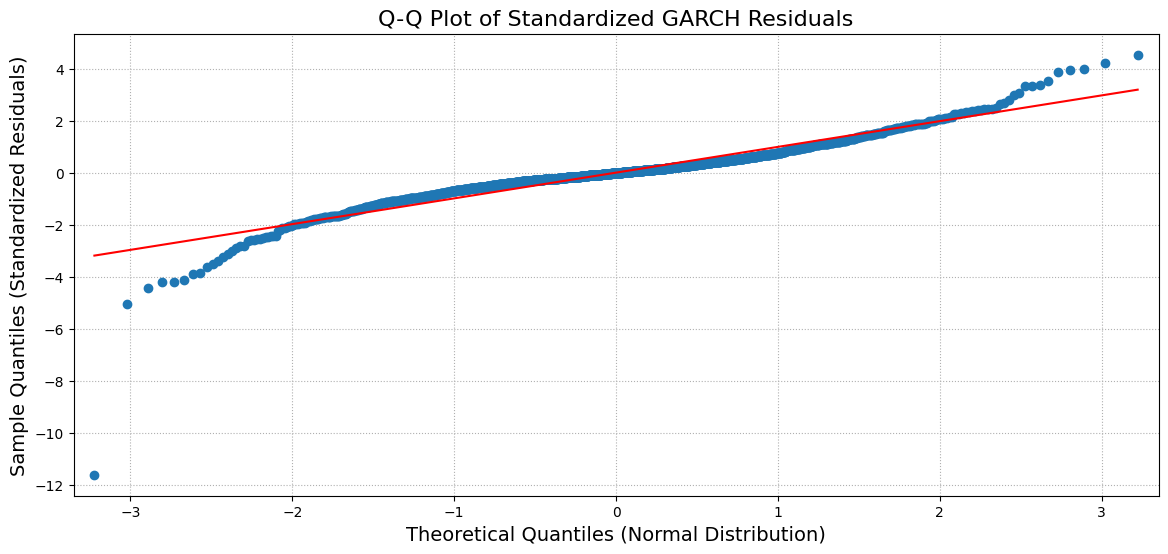

In [25]:
std_residuals_garch = garch_results.std_resid
fig_qq_std_resid = plt.figure(figsize=(14, 6))
sm.qqplot(std_residuals_garch, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Standardized GARCH Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles (Normal Distribution)', fontsize=14)
plt.ylabel('Sample Quantiles (Standardized Residuals)', fontsize=14)
plt.grid(True, linestyle=':')
plt.show()

**Visualisation of actual vs simulated Bitcoin price including important metrics**


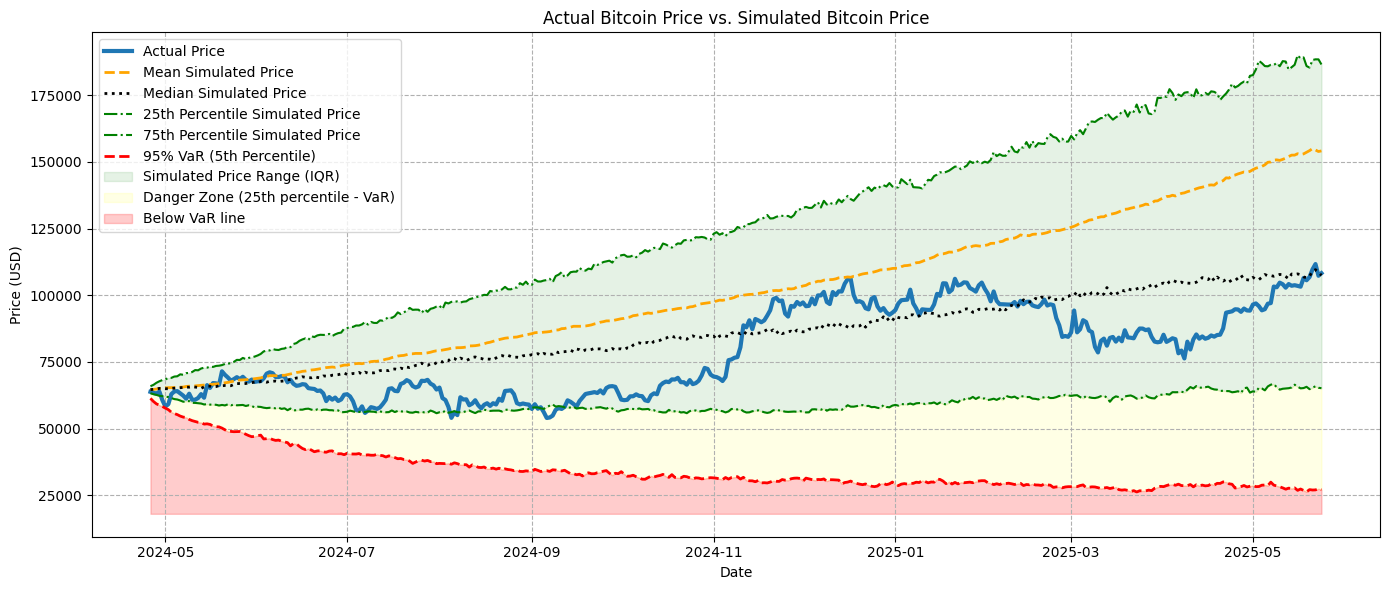

In [26]:
# calc mean + median simulated prices
mean_sim_prices = sim_prices_df.mean(axis=1)
median_sim_prices = sim_prices_df.median(axis=1)

# calc IQR
percentile_25_sim_price = sim_prices_df.quantile(0.25, axis=1)
percentile_75_sim_price = sim_prices_df.quantile(0.75, axis=1)

# calc 95% VaR
percentile_5_sim_price = sim_prices_df.quantile(0.05, axis=1)

# plotting
plt.figure(figsize=(14, 6))

# actual bitcoin price plotted
plt.plot(test_data["Close"].index, test_data["Close"],
         label="Actual Price",
         linewidth=3)

# mean simulated price plotted
plt.plot(mean_sim_prices.index, mean_sim_prices,
         label="Mean Simulated Price",
         color='orange',
         linestyle='--',
         linewidth=2)

# median simulated price plotted
plt.plot(median_sim_prices.index, median_sim_prices,
         label="Median Simulated Price",
         color='black',
         linestyle=':',
         linewidth=2)

# 25th percentile plotted
plt.plot(percentile_25_sim_price.index, percentile_25_sim_price,
         label="25th Percentile Simulated Price",
         color='green',
         linestyle='-.')

# 75th percentile plotted
plt.plot(percentile_75_sim_price.index, percentile_75_sim_price,
         label="75th Percentile Simulated Price",
         color='green',
         linestyle='-.')

# VaR plotted
plt.plot(percentile_5_sim_price.index, percentile_5_sim_price,
         label="95% VaR (5th Percentile)",
         color='red',
         linestyle='--',
         linewidth=2)

# shaded region for IQR
plt.fill_between(percentile_25_sim_price.index,
                 percentile_25_sim_price,
                 percentile_75_sim_price,
                 color='green',
                 alpha=0.1,
                 label="Simulated Price Range (IQR)")

# shaded region for danger zone (risky)
plt.fill_between(percentile_5_sim_price.index,
                 percentile_5_sim_price,
                 percentile_25_sim_price,
                 color='yellow',
                 alpha=0.1,
                 label="Danger Zone (25th percentile - VaR)")

# shaded region for danger zone (risky)
plt.fill_between(percentile_5_sim_price.index,
                 percentile_5_sim_price,
                 plt.ylim()[0],
                 color='red',
                 alpha=0.2,
                 label="Below VaR line")

plt.title("Actual Bitcoin Price vs. Simulated Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()
plt.close()